## Baselines ACH
---

* fico
* deposit v1
* customer

In [1]:
import json
import pandas as pd
import numpy as np
import pickle as pkl
from rdsutils.aws import download_s3 #, python_object_to_s3
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
import rdsutils.plot as rdsplot

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2

### Load data and some preprocessing
---

In [2]:
# using data from ach pipeline
modeling_df = pd.read_parquet('../../artifacts/final/modeling_df.parquet')
test_df = pd.read_parquet('../../artifacts/final/test_df.parquet')
modeling_df.shape, test_df.shape

((112599, 229), (152951, 229))

In [3]:
seed = 12345
target_col = 'ach_target'
modeling_df[target_col] = modeling_df['is_returned']
test_df[target_col] = test_df['is_returned']

modeling_df['account_ending_balance'] = modeling_df['real_ending_balance']
modeling_df['days_since_first_transaction'] = modeling_df['days_since_first_deposit']

test_df['account_ending_balance'] = test_df['real_ending_balance']
test_df['days_since_first_transaction'] = test_df['days_since_first_deposit']

In [4]:
display(modeling_df[target_col].value_counts(), test_df[target_col].value_counts())

False    108825
True       3774
Name: ach_target, dtype: int64

False    145410
True       7541
Name: ach_target, dtype: int64

#### Models
---
* fico
* deposit-v1
* customer

In [5]:
modeling_df['fico_pred'] = -modeling_df['fico_score']

In [6]:
test_df['fico_pred'] = -test_df['fico_score']

#### Deposit-v1

In [7]:
model_v1 = pkl.load(open('../../models/deposit-v1/money-deposit-risk-1567033961.pkl', 'rb'))

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.preprocessing.label module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.3 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
modeling_df[model_v1.feature_name_].head()

,transaction_amount,account_ending_balance,fico_score,vantage_score,fraud_score_1,fraud_score_2,email_risk_score,phone_risk_score,all8220,iqt9415,...,bcx3423,stu5031,nr_direct_deposits,nr_past_returns,days_since_first_transaction,nr_transactions_per_day,transaction_as_pct_of_balance,rolling_trns_as_pct_of_bal,transaction_as_pct_of_bal_min,rolling_mean_acc_bal
6013,88.0,35259.43,NaN,NaN,0.0163,0.428,0.197,0.005,NaN,NaN,...,NaN,NaN,51,0,847,0.773318,0.002502,0.010872,-0.085234,37835.792174
6452,120.0,6439.15,NaN,NaN,0.1072,0.493,0.001,0.102,NaN,NaN,...,NaN,NaN,0,1,785,0.442038,0.018990,0.018990,0.018990,6359.090000
6457,120.0,6472.36,NaN,NaN,0.1072,0.493,0.001,0.102,NaN,NaN,...,NaN,NaN,0,1,799,0.440551,0.018891,0.018891,0.018891,6938.360000
6458,120.0,6592.44,NaN,NaN,0.1072,0.493,0.001,0.102,NaN,NaN,...,NaN,NaN,0,1,812,0.434729,0.018540,0.018540,0.018540,6532.400000
6460,120.0,6712.44,NaN,NaN,0.1072,0.493,0.001,0.102,NaN,NaN,...,NaN,NaN,0,1,827,0.429262,0.018203,0.018203,0.018203,6652.440000


<AxesSubplot:>

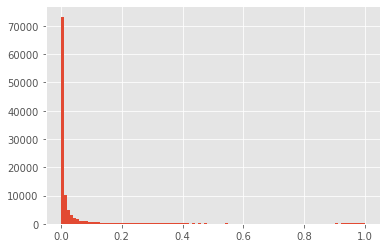

In [9]:
for feature in model_v1.feature_name_:
    modeling_df[feature] = modeling_df[feature].astype(float)
    
pred = model_v1.predict_proba(modeling_df[model_v1.feature_name_],
                              num_iteration=model_v1.best_iteration_)[:,1]
modeling_df['deposit_v1_pred'] = pred
modeling_df['deposit_v1_pred'].hist(bins=100)

<AxesSubplot:>

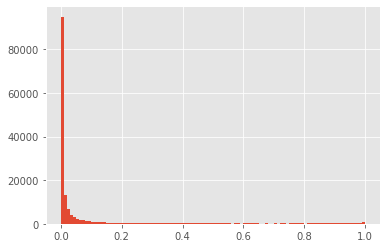

In [10]:
for feature in model_v1.feature_name_:
    test_df[feature] = test_df[feature].astype(float)
    
pred = model_v1.predict_proba(test_df[model_v1.feature_name_],
                              num_iteration=model_v1.best_iteration_)[:,1]
test_df['deposit_v1_pred'] = pred
test_df['deposit_v1_pred'].hist(bins=100)

#### Customer Model

In [11]:
from customer_utils import preprocess

In [12]:
customer_risk = pkl.load(open('../../models/customer-risk/customer_risk_target_no_giact_time_since_last_link.pkl', 'rb'))

In [13]:
modeling_df_customer = modeling_df.copy()
modeling_df_customer = preprocess(modeling_df_customer)
modeling_df_customer[customer_risk.feature_name_].head()

,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,name_email_correlation,transaction_as_pct_of_balance,mean_account_balance_30d,phone_risk_score,name_address_correlation,...,nr_trans_ratio,iqt9413,dollar_val_returns_3d,nr_returns_30d,credit_card_loan_amount,fraud_score_1,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
6013,100.0,NaN,NaN,0.197,0.428,0.9959,0.002502,37490.369268,0.005,0.9096,...,0.075000,NaN,0.0,0.0,NaN,0.0163,848,2,-1.0,-1.0
6452,500.0,NaN,NaN,0.001,0.493,0.9954,0.018990,6295.078000,0.102,0.9096,...,0.200000,NaN,0.0,0.0,NaN,0.1072,837,2,-1.0,-1.0
6457,500.0,NaN,NaN,0.001,0.493,0.9954,0.018891,6721.133750,0.102,0.9096,...,0.125000,NaN,0.0,0.0,NaN,0.1072,851,2,-1.0,-1.0
6458,500.0,NaN,NaN,0.001,0.493,0.9954,0.018540,6817.627143,0.102,0.9096,...,0.142857,NaN,0.0,0.0,NaN,0.1072,864,2,-1.0,-1.0
6460,500.0,NaN,NaN,0.001,0.493,0.9954,0.018203,6592.420000,0.102,0.9096,...,0.250000,NaN,0.0,0.0,NaN,0.1072,879,2,-1.0,-1.0


In [14]:
test_df_customer = test_df.copy()
test_df_customer = preprocess(test_df_customer)
test_df_customer[customer_risk.feature_name_].head()

,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,name_email_correlation,transaction_as_pct_of_balance,mean_account_balance_30d,phone_risk_score,name_address_correlation,...,nr_trans_ratio,iqt9413,dollar_val_returns_3d,nr_returns_30d,credit_card_loan_amount,fraud_score_1,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
6470,500.0,NaN,NaN,0.001,0.493,0.9954,0.016047,7301.787778,0.102,0.9096,...,0.125000,NaN,0.0,0.0,NaN,0.1072,931,2,-1.0,-1.0
6472,500.0,NaN,NaN,0.001,0.493,0.9954,0.014129,7529.284545,0.102,0.9096,...,0.111111,NaN,0.0,0.0,NaN,0.1072,935,2,-1.0,-1.0
6474,500.0,NaN,NaN,0.001,0.493,0.9954,0.016047,7761.750000,0.102,0.9096,...,0.142857,NaN,0.0,0.0,NaN,0.1072,949,2,-1.0,-1.0
6477,500.0,NaN,NaN,0.001,0.493,0.9954,0.015793,7870.945714,0.102,0.9096,...,0.166667,NaN,0.0,0.0,NaN,0.1072,963,2,-1.0,-1.0
6483,500.0,NaN,NaN,0.001,0.493,0.9954,0.016671,7469.954000,0.102,0.9096,...,0.142857,NaN,0.0,0.0,NaN,0.1072,977,2,-1.0,-1.0


<AxesSubplot:>

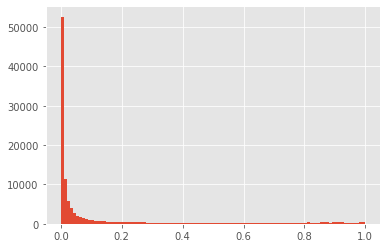

In [15]:
pred = customer_risk.predict_proba(modeling_df_customer[customer_risk.feature_name_],
                                   num_iteration=customer_risk.best_iteration_)[:,1]
modeling_df['customer_pred'] = pred
modeling_df['customer_pred'].hist(bins=100)

<AxesSubplot:>

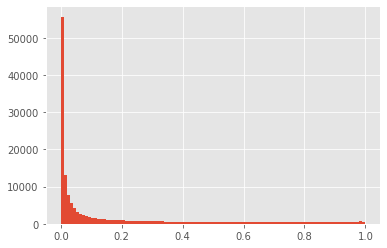

In [16]:
pred = customer_risk.predict_proba(test_df_customer[customer_risk.feature_name_],
                                   num_iteration=customer_risk.best_iteration_)[:,1]
test_df['customer_pred'] = pred
test_df['customer_pred'].hist(bins=100)

### Refit Customer
---

In [17]:
customer_params = customer_risk.get_params()
features_c = customer_risk.feature_name_

customer_params['verbosity'] = -1
# customer_params['scale_pos_weight'] *= 2  # TEST THIS!!!

In [18]:
params_ = {'num_boost_round': 1372,
 'num_threads': -1,
 'objective': 'binary',
 'verbose': -1,
 'boosting_type': 'gbdt',
 'two_round': True,
 'metric': 'auc',
 'boosting': 'gbdt',
 'tree_learner': 'feature',
 'boost_from_average': 'false',
 'num_leaves': 17,
 'lambda_l1': 25.397477554931353,
 'lambda_l2': 22.580936083946675,
 'min_data_in_leaf': 28,
 'max_depth': 5,
 'learning_rate': 0.09170176135638021,
 'feature_fraction': 0.2513960815698203,
 'scale_pos_weight': 55.219917012448136,
 'early_stopping_round': 300,
 'seed': 12345,
 'seed_value': 12345}

for p in params_:
    customer_params[p] = params_[p]

In [19]:
result = train_lgb_baseline_grouped(modeling_df_customer, features_c, 
                                    customer_params, target_col, seed=seed)
pred_c, fimp_c, models_c, auc_c = result

# evaluate on modeling_df
modeling_df['refitted_customer_pred'] = pred_c

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in par

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: seed_value
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.2513960815698203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2513960815698203
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l1 is set=25.397477554931353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25.397477554931353
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] lambda_l2 is set=22.580936083946675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.580936083946

In [20]:
test_df_customer = test_df.copy()
test_df_customer = preprocess(test_df_customer)

In [21]:
# genereate OOT preds
import lightgbm as lgb

customer_params['early_stopping_round'] = None

clf = lgb.LGBMClassifier(**customer_params)
X = modeling_df_customer[features_c]
y = modeling_df_customer[target_col]

clf.fit(X, y)
test_df['refitted_customer_pred'] = clf.predict_proba(test_df_customer[features_c])[:,1]

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/basic.py:1077: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical

[LightGBM] [Warning] Unknown parameter: seed_value
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] num_iterations is set=1372, num_boost_round=1372 will be ignored. Current value: num_iterations=1372
[LightGBM] [Warning] lambda_l1 is set=25.397477554931353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25.397477554931353
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] lambda_l2 is set=22.580936083946675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.580936083946675
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.2513960815698203, colsample_bytree=1.0 will be ignored. Current value: feature_fract

#### Compare Results
---

In [22]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from rdsutils.plot import plot_auc_curve_mult, plot_pr_curve_mult, plot_feature_over_time

plt.style.use('seaborn')

def get_binary_metrics(y_true, y_pred):
    from sklearn.metrics import roc_auc_score, average_precision_score
    from scikitplot.helpers import binary_ks_curve
    
    auc = round(roc_auc_score(y_true=y_true,
                              y_score=y_pred)*100, 2)
    ap = round(average_precision_score(y_true=y_true,
                                       y_score=y_pred)*100, 2)
    _, _, _, ks, _, _ = binary_ks_curve(y_true=y_true, y_probas=y_pred)
    ks = round(ks*100, 2) 
    
    metrics = {'auc': auc,
               'ap': ap,
               'ks': ks}

    return metrics


def get_pred_reports(df, target_col, pred_cols):
    import pandas as pd
    result = {}
    for col in pred_cols:
        metrics = get_binary_metrics(df[target_col], df[col])
        result[col] = metrics
    return pd.DataFrame(result).T

### Comparison
---

#### without FICO

In [23]:
target_col = 'ach_target'

In [24]:
# for slides
metrics = get_pred_reports(modeling_df, target_col, 
                           ['deposit_v1_pred', 
                            'refitted_customer_pred'])
metrics

,auc,ap,ks
deposit_v1_pred,85.06,27.62,56.89
refitted_customer_pred,92.60,61.75,70.73


In [25]:
# for slides
metrics = get_pred_reports(modeling_df, target_col, 
                           ['deposit_v1_pred', 
                            'refitted_customer_pred'])
metrics

,auc,ap,ks
deposit_v1_pred,85.06,27.62,56.89
refitted_customer_pred,92.60,61.75,70.73


(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'Precision-Recall curve: Baseline Comparison'}, xlabel='Recall', ylabel='Precision'>)

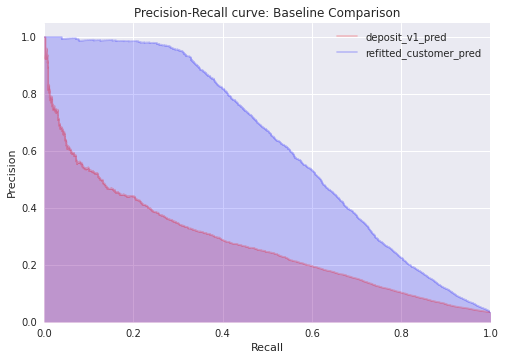

In [26]:
preds = [(modeling_df['deposit_v1_pred'], 'deposit_v1_pred'), 
         (modeling_df['refitted_customer_pred'], 'refitted_customer_pred')]
title = 'Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(modeling_df[target_col], preds,
                   title=title, colors = ['r', 'b'])

(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'AUC-ROC curve: Baseline Comparison'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

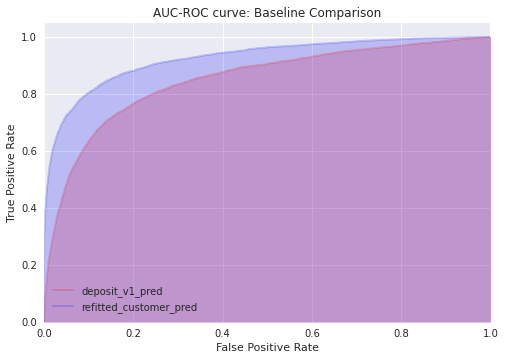

In [27]:
title = 'AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(modeling_df[target_col], preds,
                   title=title, colors = ['r', 'b'])

#### with FICO

In [28]:
df_w_fico = modeling_df[(~modeling_df.fico_score.isna()) 
                        & (modeling_df.fico_score <= 850)]
# logically good fico score -> lower fraud prob
# flip the direction to match with target 

metrics = get_pred_reports(df_w_fico, target_col, 
                           ['fico_pred', 
                            'deposit_v1_pred', 
                            'refitted_customer_pred'])
metrics

,auc,ap,ks
fico_pred,85.43,18.12,60.65
deposit_v1_pred,83.74,23.36,54.39
refitted_customer_pred,91.84,58.37,69.03


(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'Precision-Recall curve: Baseline Comparison'}, xlabel='Recall', ylabel='Precision'>)

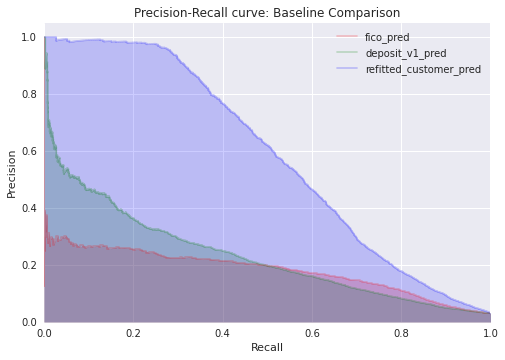

In [29]:
preds = [(df_w_fico['fico_pred'], 'fico_pred'),
         (df_w_fico['deposit_v1_pred'], 'deposit_v1_pred'), 
         (df_w_fico['refitted_customer_pred'], 'refitted_customer_pred')]
title = 'Precision-Recall curve: Baseline Comparison'
rdsplot.plot_pr_curve_mult(df_w_fico[target_col], preds,
                           title=title, colors = ['r', 'g', 'b'])

(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'AUC-ROC curve: Baseline Comparison'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

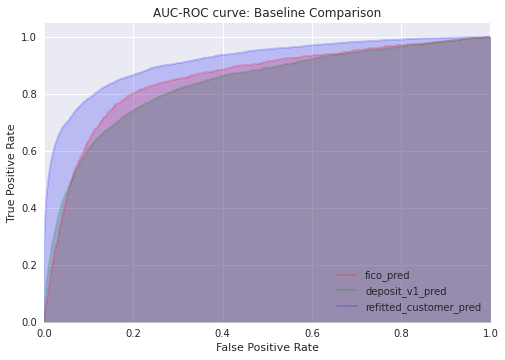

In [30]:
title = 'AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(df_w_fico[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'])

### Check result and output to artifacts
---

In [31]:
modeling_df[['fico_pred', 'deposit_v1_pred', 'refitted_customer_pred']].head()

,fico_pred,deposit_v1_pred,refitted_customer_pred
6013,NaN,0.004101,0.084913
6452,NaN,0.094721,0.297537
6457,NaN,0.087164,0.281424
6458,NaN,0.087164,0.302244
6460,NaN,0.087164,0.333705


In [32]:
test_df[['fico_pred', 'deposit_v1_pred', 'refitted_customer_pred']].head()

,fico_pred,deposit_v1_pred,refitted_customer_pred
6470,NaN,0.034147,0.011054
6472,NaN,0.063482,0.006616
6474,NaN,0.067192,0.024017
6477,NaN,0.066098,0.014138
6483,NaN,0.041774,0.015245


In [33]:
modeling_df.to_parquet('../../artifacts/final/modeling_df_w_baselines.parquet')
test_df.to_parquet('../../artifacts/final/test_df_w_baselines.parquet')